In [1]:
#dataset -> https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE?resourcekey=0-01Pth1hq20K4kuGVkp3oBw

import tensorflow as tf

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
#%matplotlib inline

In [4]:
IMG_SIZE = 56

In [5]:
layers = tf.keras.layers 

def build_gen_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 64)))
    model.add(layers.Conv2DTranspose(32, 3, 2, 'same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(16, 3, 2, 'same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(1, 3, 2, 'same', use_bias=False, activation='sigmoid'))
    return model

In [6]:
def build_disc_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, 3, 2, 'same', input_shape=[56, 56, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, 3, 2, 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, 3, 2, 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(2)) # [real, fake]
    model.add(layers.Softmax())

    return model

In [7]:
with tf.device('gpu'):
    discriminator = build_disc_model() 
    generator = build_gen_model()
    cross_entropy = tf.keras.losses.CategoricalCrossentropy()
    generator_optimizer = tf.keras.optimizers.Adam(1e-3)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [8]:
def discriminator_loss(real_output, fake_output): #n,2
    real_loss = cross_entropy(tf.one_hot(tf.zeros(shape=(real_output.shape[0],), dtype='int32'), 2), real_output) #mse(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.one_hot( tf.ones(shape=(fake_output.shape[0],), dtype='int32'), 2), fake_output) #mse(-tf.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.one_hot( tf.zeros(shape=(fake_output.shape[0],), dtype='int32'), 2), fake_output)

In [10]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.path = './crop_part1'
        self.imgs = os.listdir(self.path)
    
    def __len__(self):
        return len(self.imgs)//self.batch_size
    
    def __getitem__(self, idx):
        start = self.batch_size * idx
        images = np.zeros(shape=(self.batch_size, 56,56,1), dtype='float32')
        for k in range(self.batch_size):
            img = PIL.Image.open(os.path.join(self.path, self.imgs[start+k])).convert('L')
            #img = PIL.ImageOps.grayscale(img)
            img = img.resize((56,56))
            images[k] = np.array(img).reshape((56,56,1))/255
        return images
    
    def on_epoch_end(self):
        np.random.shuffle(self.imgs)
    

In [11]:
BATCH_SIZE = 32
noise_dim = 100
dataset = Dataset(BATCH_SIZE)

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [13]:
def savefig():
    sufix = str(time.time()).replace('.', '')[:9]
    plt.savefig(f'figs/fig_{sufix}.png')

def gen():
    noise = tf.random.normal([8, 100])
    return generator(noise, training=False).numpy()

def generate_and_save_plot():
    fig, axs = plt.subplots(2, 4, figsize=(14,7))
    imgs = gen()
    for i in range(8):
        img = imgs[i]
        axs[i//4][i%4].imshow(img, cmap='gray',)
    savefig()

In [14]:
ckpt = tf.train.Checkpoint(gen_optmizer=generator_optimizer, 
                           disc_optmizer=discriminator_optimizer, 
                           generator=generator,
                           discriminator=discriminator)
manager = tf.train.CheckpointManager(ckpt, './ckpts', max_to_keep=4)

In [15]:
ckpt.restore(manager.latest_checkpoint)

In [ ]:
save_every_epoch = 20
with tf.device('gpu'):
    epochs = 5000
    for epoch in range(epochs):
        steps_per_epoch = len(dataset)
        print('\n<<EPOCH {}/{}>>'.format(epoch+1, epochs))
        for i in range(steps_per_epoch):
            data = dataset[i]
            l1, l2 = train_step(data)
            if i%10 == 0:
                print('\rstep: {}/{}\t|\tGen Loss: {:.3f}\t|\tDisc Loss: {:.3f}\t\t'.format(i+1,
                                                                                            steps_per_epoch,
                                                                                            l1.numpy(),
                                                                                            l2.numpy()),
                      end='')
        if epoch > 0 and not epoch%save_every_epoch:
            manager.save()
        print()

        dataset.on_epoch_end()
        generate_and_save_plot()

In [17]:
import imageio

In [20]:
img_dir = './figs'
imgs = []
for filename in os.listdir(img_dir):
    imgs.append(np.array(PIL.Image.open(os.path.join(img_dir, filename))))
imageio.mimsave('./progress.gif', imgs, duration=0.25)

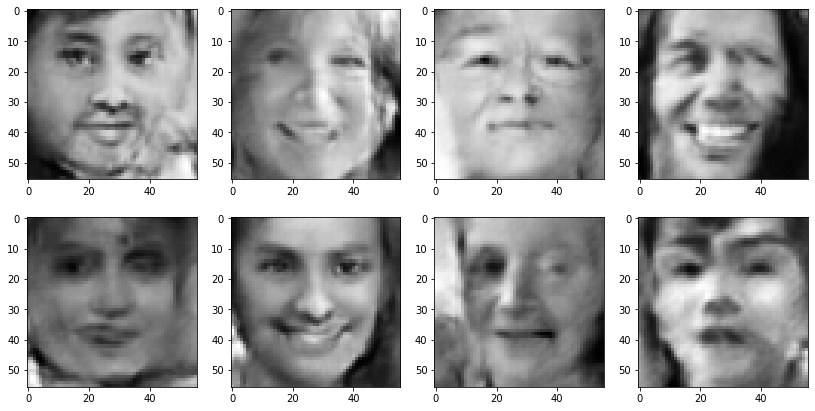

In [19]:
generate_and_save_plot()